In [0]:
import numpy as np
import networkx as nx
import pandas as pd
import random
import functools
from itertools import combinations 
import math

In [5]:
path = 'edges.csv'
graph = nx.Graph()
edges = pd.read_csv(path, sep=',', header=None)
graph.add_edges_from(edges.values)
nx.info(graph)

'Name: \nType: Graph\nNumber of nodes: 10312\nNumber of edges: 333983\nAverage degree:  64.7756'

In [0]:
from itertools import combinations 
import numpy as np
import networkx as nx
import math
# from igraph import *


def apply(graph, func):
    non_edges = nx.non_edges(graph)
    return ((u, v, func(u, v)) for u, v in non_edges)

def CN_score(graph,u,v):
        return len(list(w for w in graph[u] if w in graph[v] and w not in (u, v)))

def common_neighbors_score(graph): 
    non_edges = nx.non_edges(graph)
    def score(u,v):
        return len(list(w for w in graph[u] if w in graph[v] and w not in (u, v)))

    return ((u, v, score(u, v)) for u, v in non_edges) 


def AA_score(graph, u, v):
        return sum(1 / math.log(graph.degree(w))for w in nx.common_neighbors(graph, u, v))

def adamic_adar_score(graph):
    non_edges = nx.non_edges(graph)
    def score(u, v):
        return sum(1 / math.log(graph.degree(w))for w in nx.common_neighbors(graph, u, v))

    return ((u, v, score(u, v)) for u, v in non_edges) 

def PA_score(graph, u, v):
    return (graph.degree(u) * graph.degree(v))


def preferential_attachment_score(graph):
    non_edges = nx.non_edges(graph)
    return ((u, v, graph.degree(u) * graph.degree(v)) for u, v in non_edges)


def RA_score(graph, u, v):
        return sum(1 / graph.degree(w) for w in nx.common_neighbors(graph, u, v))

def resource_allocation_score(graph):
    non_edges = nx.non_edges(graph)
    def score(u, v):
        return sum(1 / graph.degree(w) for w in nx.common_neighbors(graph, u, v))
    return apply(graph, score, non_edges) 


def JC_score(graph, u, v):
        union_size = len(set(graph[u]) | set(graph[v]))
        if union_size == 0:
            return 0
        else:
            return len(list(nx.common_neighbors(graph, u, v))) / union_size

def jaccard_coefficient_score(graph):
    non_edges = nx.non_edges(graph)
    def score(u,v):
        union_size = len(set(graph[u]) | set(graph[v]))
        if union_size == 0:
            return 0
        else:
            return len(list(nx.common_neighbors(graph, u, v))) / union_size

    return apply(graph,score,non_edges)    


def friends_measure(graph, u, v):  #heuristic for katz
    score = 0
    for x in graph[u]:
        for y in graph[v]:
            if x == y:
                score = score + 1
            elif graph.has_edge(x,y):
                score = score + 1
    return score


def katz_score(graph,beta=0.004):
    non_edges = nx.non_edges(graph)
    A = nx.to_numpy_matrix(graph)
    # print(A)
    w, v = np.linalg.eigh(A)
    lambda1 = max([abs(x) for x in w])   # beta should be less than 1/lambda1
    # print(1/lambda1)
    if beta >= 1/lambda1 :
        raise ValueError('beta should be less than 1/lambda, lambda being the eigenvalue with largest magnitude')
    I = np.eye(A.shape[0])
    S = np.linalg.inv(I - beta * A) - I
    return S


def RP_score(graph, u, v):
    return rooted_pagerank_score(graph,u)[v] + rooted_pagerank_score(graph,v)[u]


def rooted_pagerank_score(graph, root_node, alpha = 0.85, max_iter = 100):
    if not graph.is_directed():
        D = graph.to_directed()
    else:
         D = graph
    H = nx.stochastic_graph(D)
    n = len(graph.nodes())
    H = nx.to_numpy_matrix(H).transpose()
    x = np.full((n,1),1.0 / n)
    v = np.full((n,1),0.0)
    nodes = D.nodes()
    index = 0
    for node in nodes:
        # print(node)
        # print(root_node)
        # print(index)
        if node == root_node:
            # print(1-alpha)
            v[index][0] = 1 - alpha
            break
        index = index +  1
    # print(v)

    for _ in range(max_iter):
        x = np.add(alpha*np.dot(H,x),v) # x = alpha*H*x + (1-alpha)*v

    x = np.squeeze(np.asarray(x))
    x = x /	np.sum(x)
    return dict(zip(graph.nodes(), x))


In [7]:
nodes = list(graph.nodes)
# print(nx.info(graph))
non_edges = list(nx.non_edges(graph))
edges = list(nx.edges(graph))
# print((non_edges))
m = len(edges)

# print(JC_score(graph, 1, 2))
# print(m)
marked_non_edges = random.sample(non_edges, m)
# print(len(marked_non_edges))
is_edge = [ 1 ] * m + [ 0 ] * m
    # print(len(is_edge))
df_dict = {}
df_dict['is_edge'] = is_edge

# df = pd.DataFrame(df_dict)
# print(df)
cn_scores = [ CN_score(graph,u,v) for (u,v) in edges ] + [ CN_score(graph,u,v) for (u,v) in marked_non_edges ]
df_dict['CN_score'] = cn_scores
print("Added CN scores....")

aa_scores = [ AA_score(graph,u,v) for (u,v) in edges ] + [ AA_score(graph,u,v) for (u,v) in marked_non_edges ]
df_dict['AA_score'] = aa_scores
print("Added AA scores....")

pa_scores = [ PA_score(graph,u,v) for (u,v) in edges ] + [ PA_score(graph,u,v) for (u,v) in marked_non_edges ]
df_dict['PA_score'] = pa_scores
print("Added PA scores....")

ra_scores = [ RA_score(graph,u,v) for (u,v) in edges ] + [ RA_score(graph,u,v) for (u,v) in marked_non_edges ]
df_dict['RA_score'] = ra_scores
print("Added RA scores....")

jc_scores = [ JC_score(graph,u,v) for (u,v) in edges ] + [ JC_score(graph,u,v) for (u,v) in marked_non_edges ]
df_dict['JC_score'] = jc_scores
print("Added JC scores....")

Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....


In [12]:
@functools.lru_cache(maxsize=None)
def RP_calc(u):
    return rooted_pagerank_score(graph,u)

def RP_compute(u,v):
    return RP_calc(u)[v] + RP_calc(v)[u]

print(RP_compute(1,2))
print(RP_compute(1,3))
rp_scores = [ RP_compute(u, v) for (u,v) in edges ] + [ RP_compute(u,v) for (u,v) in marked_non_edges ]
df_dict['RP_score'] = rp_scores
print("Added RP scores....")

0.00013212110484364675
0.00023779610234150801


NetworkXError: ignored

In [10]:
katz_matrix = katz_score(graph,beta=0.0005)
katz_matrix

matrix([[3.05498466e-05, 5.33192166e-04, 5.27423659e-04, ...,
         2.58450922e-07, 3.63173642e-09, 2.99694226e-09],
        [5.33192166e-04, 1.04138124e-03, 8.31556330e-04, ...,
         3.65799820e-07, 4.76506045e-08, 2.79129847e-07],
        [5.27423659e-04, 8.31556330e-04, 5.98229792e-04, ...,
         3.07297385e-07, 2.16281700e-08, 1.40042646e-08],
        ...,
        [2.58450922e-07, 3.65799820e-07, 3.07297385e-07, ...,
         2.50078023e-07, 1.37529601e-10, 1.34659150e-10],
        [3.63173642e-09, 4.76506045e-08, 2.16281700e-08, ...,
         1.37529601e-10, 2.50031299e-07, 1.29563853e-10],
        [2.99694226e-09, 2.79129847e-07, 1.40042646e-08, ...,
         1.34659150e-10, 1.29563853e-10, 2.50017870e-07]])

In [11]:
katz_scores = [ katz_matrix[nodes.index(u), nodes.index(v)] for (u,v) in edges ] + [ katz_matrix[nodes.index(u), nodes.index(v)] for (u,v) in marked_non_edges ]
df_dict['KATZ_score'] = katz_scores
print("Added KATZ scores....")

Added KATZ scores....


In [8]:
friends_measures = [ friends_measure(graph,u,v) for (u,v) in edges ] + [ friends_measure(graph,u,v) for (u,v) in marked_non_edges ]
df_dict['friends_measure'] = friends_measures
print("Added friends measure scores....")

KeyboardInterrupt: ignored

In [12]:
df = pd.DataFrame(df_dict)
print(df)

        is_edge  CN_score   AA_score  ...  RA_score  JC_score    KATZ_score
0             1        94  15.265008  ...  0.319931  0.023797  5.331922e-04
1             1        84  13.399951  ...  0.226821  0.036364  5.274237e-04
2             1        53   7.803208  ...  0.085334  0.074126  5.161140e-04
3             1         8   1.101101  ...  0.008084  0.045455  5.024357e-04
4             1        73  11.431751  ...  0.195716  0.048344  5.232693e-04
5             1        78  12.374592  ...  0.215654  0.030197  5.266336e-04
6             1        33   4.811798  ...  0.048012  0.112628  5.094772e-04
7             1        87  14.137160  ...  0.302948  0.033617  5.289087e-04
8             1        78  12.289955  ...  0.201157  0.033650  5.261632e-04
9             1        32   4.680326  ...  0.045620  0.161616  5.086954e-04
10            1        30   4.228659  ...  0.031319  0.122449  5.084389e-04
11            1        42   6.477862  ...  0.131175  0.044071  5.138821e-04
12          

In [0]:
is_same_community = [ nx.has_path(graph,u,v) for (u,v) in edges ] + [ nx.has_path(graph,u,v) for (u,v) in marked_non_edges ]


In [0]:
df_dict['in_same_community'] = is_same_community

In [15]:
df = pd.DataFrame(df_dict)
print(df)

        is_edge  CN_score   AA_score  ...  JC_score    KATZ_score  in_same_community
0             1        94  15.265008  ...  0.023797  5.331922e-04               True
1             1        84  13.399951  ...  0.036364  5.274237e-04               True
2             1        53   7.803208  ...  0.074126  5.161140e-04               True
3             1         8   1.101101  ...  0.045455  5.024357e-04               True
4             1        73  11.431751  ...  0.048344  5.232693e-04               True
5             1        78  12.374592  ...  0.030197  5.266336e-04               True
6             1        33   4.811798  ...  0.112628  5.094772e-04               True
7             1        87  14.137160  ...  0.033617  5.289087e-04               True
8             1        78  12.289955  ...  0.033650  5.261632e-04               True
9             1        32   4.680326  ...  0.161616  5.086954e-04               True
10            1        30   4.228659  ...  0.122449  5.084389e-04

In [0]:
df_dict['node1'] = [ x[0] for x in edges ] + [ x[0] for x in marked_non_edges]
df_dict['node2'] = [ x[1] for x in edges ] + [ x[1] for x in marked_non_edges]

In [24]:
df = pd.DataFrame(df_dict)
print(df)

        is_edge  CN_score   AA_score  ...  in_same_community  node1  node2
0             1        94  15.265008  ...               True      1    176
1             1        84  13.399951  ...               True      1    233
2             1        53   7.803208  ...               True      1    283
3             1         8   1.101101  ...               True      1    371
4             1        73  11.431751  ...               True      1    394
5             1        78  12.374592  ...               True      1    446
6             1        33   4.811798  ...               True      1    585
7             1        87  14.137160  ...               True      1    645
8             1        78  12.289955  ...               True      1    667
9             1        32   4.680326  ...               True      1    696
10            1        30   4.228659  ...               True      1    753
11            1        42   6.477862  ...               True      1    792
12            1        47

In [0]:
from google.colab import files
df.to_csv('prepared_datset2.csv', index= False)
files.download('prepared_datset2.csv')

In [0]:
df_shuffled = df.sample(frac=1).reset_index(drop=True)

In [19]:
df_shuffled

,is_edge,CN_score,AA_score,PA_score,RA_score,JC_score,KATZ_score,in_same_community
0,0,1,0.133753,194,0.000566,0.010204,2.627807e-07,True
1,0,0,0.000000,111,0.000000,0.000000,2.723895e-09,True
2,1,9,1.369736,11713,0.015713,0.009945,5.026439e-04,True
3,1,18,2.714050,10455,0.033693,0.094737,5.050276e-04,True
4,0,0,0.000000,32,0.000000,0.000000,2.039563e-09,True
5,0,5,0.682044,2875,0.003542,0.037037,1.433840e-06,True
6,1,24,3.792978,78372,0.060581,0.018706,5.078270e-04,True
7,1,2,0.281332,744,0.001934,0.020202,5.005447e-04,True
8,1,23,3.373946,40232,0.040481,0.050000,5.070834e-04,True
9,1,18,2.969939,12444,0.074217,0.087379,5.049762e-04,True


In [0]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

In [0]:
y = df_shuffled['is_edge']

In [0]:
X = df_shuffled.drop(['is_edge'],axis =1)

In [0]:
X['in_same_community'] = X['in_same_community'].map({True: 1, False: 0})

In [37]:
X

,CN_score,AA_score,PA_score,RA_score,JC_score,KATZ_score,in_same_community
0,1,0.133753,194,0.000566,0.010204,2.627807e-07,1
1,0,0.000000,111,0.000000,0.000000,2.723895e-09,1
2,9,1.369736,11713,0.015713,0.009945,5.026439e-04,1
3,18,2.714050,10455,0.033693,0.094737,5.050276e-04,1
4,0,0.000000,32,0.000000,0.000000,2.039563e-09,1
5,5,0.682044,2875,0.003542,0.037037,1.433840e-06,1
6,24,3.792978,78372,0.060581,0.018706,5.078270e-04,1
7,2,0.281332,744,0.001934,0.020202,5.005447e-04,1
8,23,3.373946,40232,0.040481,0.050000,5.070834e-04,1
9,18,2.969939,12444,0.074217,0.087379,5.049762e-04,1


In [0]:
# indexes = X.index
# columns = X.columns
scaler = MinMaxScaler(feature_range=(0, 1))
# X = scaler.fit_transform(X)
X = pd.DataFrame(scaler.fit_transform(X.values), columns=X.columns, index=X.index)

In [39]:
X

,CN_score,AA_score,PA_score,RA_score,JC_score,KATZ_score,in_same_community
0,0.000432,0.000251,1.231763e-05,0.000013,0.010204,2.301977e-04,0.0
1,0.000000,0.000000,7.020411e-06,0.000000,0.000000,2.386146e-06,0.0
2,0.003891,0.002575,7.474823e-04,0.000350,0.009945,4.403195e-01,0.0
3,0.007782,0.005101,6.671943e-04,0.000751,0.094737,4.424077e-01,0.0
4,0.000000,0.000000,1.978479e-06,0.000000,0.000000,1.786666e-06,0.0
5,0.002162,0.001282,1.834242e-04,0.000079,0.037037,1.256054e-03,0.0
6,0.010376,0.007129,5.001787e-03,0.001350,0.018706,4.448600e-01,0.0
7,0.000865,0.000529,4.741968e-05,0.000043,0.020202,4.384806e-01,0.0
8,0.009944,0.006342,2.567619e-03,0.000902,0.050000,4.442086e-01,0.0
9,0.007782,0.005582,7.941361e-04,0.001654,0.087379,4.423626e-01,0.0


In [0]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [41]:
kfold = model_selection.KFold(n_splits=5, random_state=22, shuffle = True)
model_kfold = DecisionTreeClassifier(random_state=0)
results_kfold = model_selection.cross_val_score(model_kfold, X, y, cv=5, scoring='roc_auc')
print(results_kfold)
print("Accuracy: %.2f%%" % (results_kfold.mean()*100.0)) 

[1. 1. 1. 1. 1.]
Accuracy: 100.00%


In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [45]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

        Specs          Score
5  KATZ_score  149957.825372
0    CN_score    6009.300830
4    JC_score    4690.868625
1    AA_score    4623.322931
2    PA_score    2803.592634
3    RA_score    1766.826813


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.06954236 0.03200694 0.00323295 0.00546193 0.01300981 0.87674602
 0.        ]


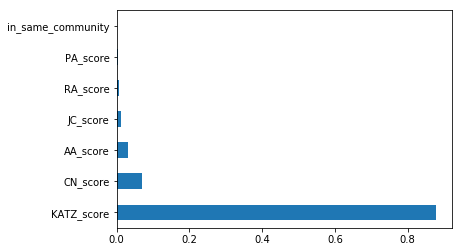

In [46]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(9).plot(kind='barh')
plt.show()

In [0]:
import seaborn as sns

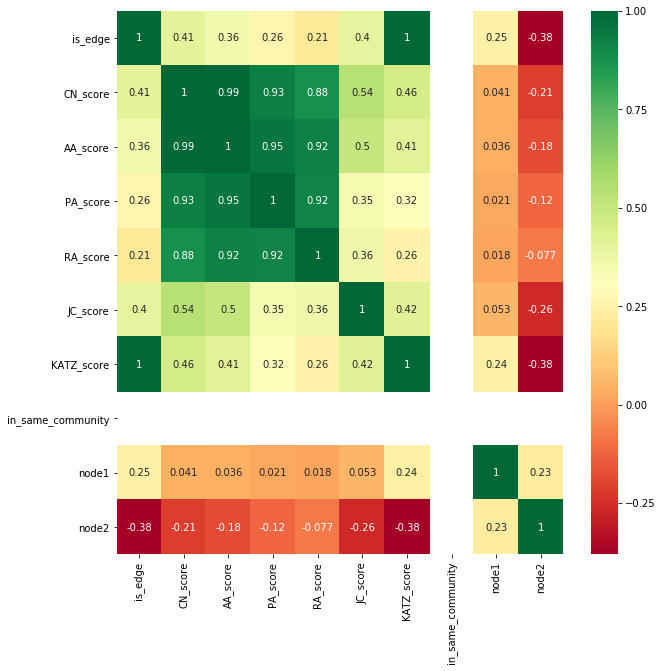

In [49]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")